# Reconstruct from traces

Purpose of this notebook :

* Convert Tincan records to usable network images 
* Extract some first metrics
* Create preliminary viz of the activity
* Check test data

Tincan/XAPI records have already been stored in MongoDB using a [custom xApi crawler script](https://github.com/sical/meta-education/blob/master/xapi/xapi-crawler.py) 

In [7]:
import json
import os
from pymongo import MongoClient
import datetime

# import config
with open(os.path.join(os.getcwd(),"../config/config.json"),"rb") as f:
    config = json.load(f)

# connect to mongo
client = MongoClient('localhost', 27017)
db = client["metaEducation"] 

### Parser functions

Functions used to convert Tincan API answers into networks

In [8]:
def get_action(type):
    if type[-1] == "/":
        return type.split("/")[-2]
    else :
        return type.split("/")[-1]

# statements parsers 
def parse_create(G, statement):
    element_type = statement["object"]["definition"]["type"].split("#")[1]
    data = statement["object"]["definition"]["extensions"]["http://www-w3-org/ns/activitystreams#Data"] 
    if element_type == "Node" :
        G.add_node(data["_id"], attr_dict=data)
    elif element_type == "Edge" :
        G.add_edge(data["from"], data["to"], attr_dict=data)
    else :
        raise ValueError("Wrong element type %s"%element_type)
    return G

def parse_delete(G, statement):
    element_type = statement["object"]["definition"]["type"].split("#")[1]
    data = statement["object"]["definition"]["extensions"]["http://www-w3-org/ns/activitystreams#Data"] 
    if element_type == "Node" :
        G.remove_node(data["_id"])
    elif element_type == "Edge" :
        G.remove_edge(data["from"], data["to"])
    else :
        raise ValueError("Wrong element type %s"%element_type)
    return G

def parse_update(G, statement):
    element_type = statement["object"]["definition"]["type"].split("#")[1]
    data = statement["object"]["definition"]["extensions"]["http://www-w3-org/ns/activitystreams#Data"] 
    try :  
        data_changed = statement["object"]["definition"]["extensions"]["http://www-w3-org/ns/activitystreams#DataChanged"] 
        if element_type == "Node" :
            for change in data_changed:
                G.node[data["_id"]][change] = data_changed[change]
        else :
            raise ValueError("Wrong element type %s"%element_type)
    except KeyError:
        return None # ignore if nothing in DataChanges
    return G


### Use test data to parse networks

303 results
----------
Final state: 9 nodes and 8 edges in 151 actions
----------
update 103
create 22
move 22
delete 4
----------


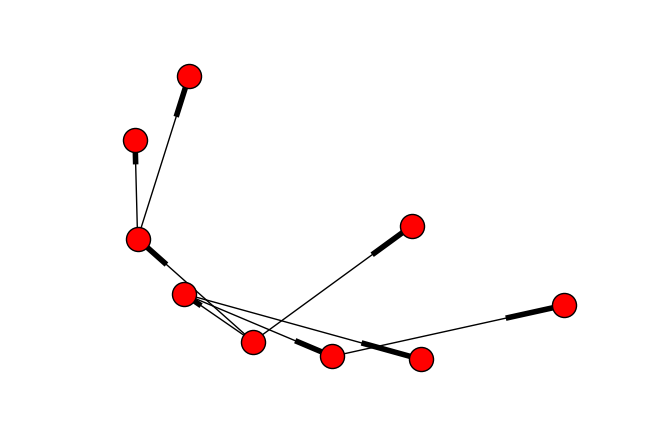

In [9]:
from collections import Counter 
import networkx as nx

# convert date string to datetime object
start = datetime.datetime(2016, 9, 8, 13, 0, 0)
end = datetime.datetime(2016, 9, 8, 13, 50, 0)

# query
q = { 'stored': {'$lt': end, '$gte': start} }

print "%s results"%db.statements.find(q).count()
print "-"*10

# store different informations about the network
G = nx.DiGraph()
actions = []
network_states=[]

# extract infos 
for statement in db.statements.find(q):
    
    # default state 
    hasChanged=None
    
    # store action infos
    action = {}
    action["type"] = get_action(statement["verb"]["id"])
    action["ts"] = statement["stored"]
        
    # parse network 
    if action["type"] == "create": hasChanged = parse_create(G, statement)
    elif action["type"] == "delete": hasChanged = parse_delete(G, statement)
    elif action["type"] == "move": hasChanged = parse_update(G, statement)
    elif action["type"] == "update": hasChanged = parse_update(G, statement)
    elif action["type"] == "access": pass
    elif action["type"] == "loggedin": pass
    else :raise ValueError("Unknown action: %s"%action)
    
    if hasChanged : # make sure the graph has been updated 
        action["nodes"] = hasChanged.nodes() 
        action["edges"] = hasChanged.edges()
        actions.append(action)


actions.sort(key=lambda c: c["ts"]) # sort by time

print "Final state: %s nodes and %s edges in %s actions"%(len(G.nodes()), len(G.edges()), len(actions))
print "-"*10

for c in Counter([a["type"] for a in actions]).most_common() : print c[0], c[1]
print "-"*10

nx.draw(G)

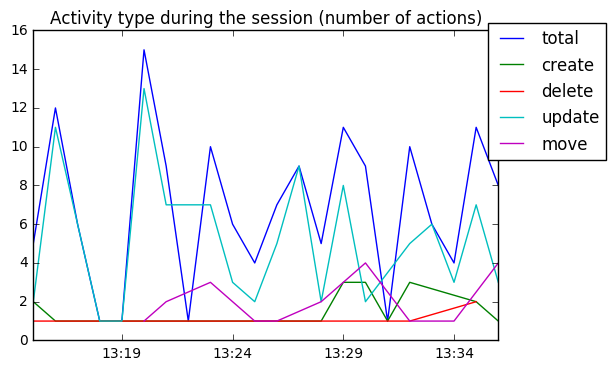

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import dates as mdates

def roundTime(dt=None, roundTo=60):
   """Round a datetime object to any time laps in seconds
   dt : datetime.datetime object, default now.
   roundTo : Closest number of seconds to round to, default 1 minute.
   Author: Thierry Husson 2012 - Use it as you want but don't blame me.
   """
   if dt == None : dt = datetime.datetime.now()
   seconds = (dt.replace(tzinfo=None) - dt.min).seconds
   rounding = (seconds+roundTo/2) // roundTo * roundTo
   return dt + datetime.timedelta(0,rounding-seconds,-dt.microsecond)


def get_actions_count_per_minutes(actions):
    
    # round timestamps to activity by minutes
    timestamps = [ roundTime(a["ts"]) for a in actions]

    # count 
    count = Counter(timestamps).most_common() 
    count.sort(key=lambda c: c[0]) # sort by time

    x = [c[0] for c in count] # time
    y = [c[1] for c in count] # values
    return x, y


# draw
fig, ax = plt.subplots(1, 1)
hfmt = mdates.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(hfmt)

# plot time activity 
x_time, y_total = get_actions_count_per_minutes(actions)
plt.plot(x_time, y_total)

x_time, y_create = get_actions_count_per_minutes([a for a in actions if a["type"] == "create"])
plt.plot(x_time, y_create)

x_time, y_delete = get_actions_count_per_minutes([a for a in actions if a["type"] == "delete"])
plt.plot(x_time, y_delete)

x_time, y_delete = get_actions_count_per_minutes([a for a in actions if a["type"] == "update"])
plt.plot(x_time, y_delete)

x_time, y_move = get_actions_count_per_minutes([a for a in actions if a["type"] == "move"])
plt.plot(x_time, y_move)

plt.legend(['total', 'create', 'delete', 'update', 'move'], loc='upper right', bbox_to_anchor=(1.25, 1.05))
plt.title("Activity type during the session (number of actions)")

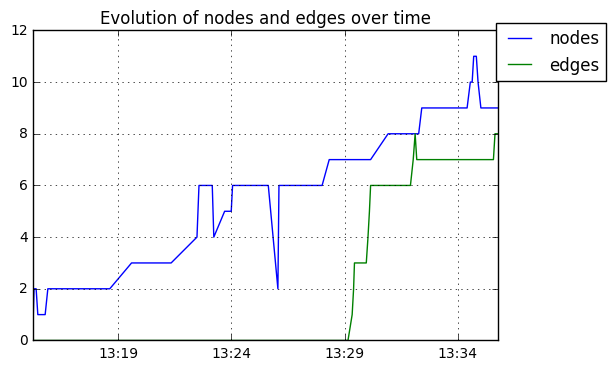

In [16]:
import numpy as np

# network size evolution

fig, ax = plt.subplots(1, 1)

# grid
hfmt = mdates.DateFormatter('%H:%M')
ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=3))
ax.xaxis.set_major_formatter(hfmt)

ax.grid(which='both')     

x = [a["ts"] for a in actions]
y_nodes_count = [len(a["nodes"]) for a in actions]
y_edges_count = [len(a["edges"]) for a in actions]

plt.plot(x, y_nodes_count)
plt.plot(x, y_edges_count)
plt.legend(['nodes', 'edges'], loc='upper right', bbox_to_anchor=(1.25, 1.05))
plt.title("Evolution of nodes and edges over time")